## GNN Layer implementation from Scratch

In this notebook I am going to implement from scratch a Layer module. Specifically we will use it for node classification on CORA, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node.

In [29]:
import os
import torch
import torch_geometric
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax


We now create a wrapper class which will instantiate either a GAT or a GraphSAGE stack of GNN layers. We will need to implement such layers then.

In [30]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False) -> None:
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type) # it returns an instance of the type of layer we want to use, such as GraphSage and GAT
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1): # we stop before the last layer
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))
        
        
        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb
        
    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage # <-- we will implement 
        elif model_type == 'GAT':
            # Notice that if we want to use multi-heads we need to change a bit the previous __init__, 
            # to match the input and output dimensions of consecutive layers
            return GAT # <-- we will implement
        else:
            raise ValueError(f"Unknown model type {model_type}")
        
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch # batch is mainly used in case of global pooling for graph level tasks
        
        for l in range(self.num_layers):
            x = self.convs[l](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout, training = self.training) # only used during training
        
        x = self.post_mp(x)
        
        if self.emb:
            return x
        
        return F.log_softmax(x, dim=1)
    
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)
            
        



## Create Custom Message Passing Layer

Useful links: [Link 1](https://zqfang.github.io/2021-08-07-graph-pyg/)


From a node point of view we will perform the following:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_l, W_r$ are the learnable parameter matrices for the layer. As aggregation, we use the mean:


\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Notice that the above implementation differs from the original one where the node embedding $v$ is actually concatenated with the neighbor summary and then passed through a linear layer. Here we directly pass it through a sort of skip-connection with $W_l$.


The 3 main functions to implement are the `forward`, the `message`, and the `aggregate` functions. Specifically:


- `forward`: takes care of doing the preprocessing of the embeddings from the previous layers, calling the propagate function, and then handling the post processing. The propagate function, handles the call for the message computation and the aggregation of such messages.
- `message`
- `propagate`




In [31]:
from typing import Any, Dict, List


from torch_geometric.nn.aggr import Aggregation
from torch_geometric.utils import degree, add_self_loops


class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs) -> None:
        super(GraphSage, self).__init__(**kwargs)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = nn.Linear(in_channels, out_channels)
        self.lin_r = nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    
    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        
        
    def message(self, x_j):
        """
        Constructs the message to be passed to each node's neighbors. Called by the propagate function.

        Args:
            x_j (Tensor): The feature matrix of neighboring nodes. This is equivalent to X[edge_index[:,2], :], so the features of end nodes.
            

        Returns:
            Tensor: The messages to be aggregated
        """
        # Each node simply send its own embedding to the neighbors
        return x_j 
    
    def aggregate(self, inputs, index, dim_size):
        """
        Function to aggregate the messages of neighboring nodes. It is called by the propagate function.
        
        Args:
            inputs (Tensor): is the output of the message function. Dimension [num_of_edges_in_graph, dimension_of_previous_layer_embedding]. There are obviously many
                            duplicates since a source node is connected to multiple nodes
            index (Tensor): array where each entry indicates which node sent the associated message in inputs. The value stored at index[i] specifies the target node that the message at inputs[i] is sending to
            dim_size (int): the size of the output. In this case it is equal to the number of nodes N
             
        Returns:
            Tensor: The aggregated embedding, N x d
        """
       
        
        
        # The axis along which to perform the sum (in this case over the rows, since we aggregate the same feature of different embeddings).
        node_dim = 0
        out = torch_scatter.scatter(inputs, index, dim = node_dim, dim_size = dim_size, reduce = 'mean')
        return out
    
        
    def forward(self, x, edge_index, size = None):
        
        #we can decide whether to perform the linear transformation before of after the propagation, i.e., before or after
        # the summation of the neighborhood. 
        
        # Pre-processing
        #row, col = edge_index
        #deg = degree(row, size[0], dtype=x.dtype)
        
        # Message Passing (Message + Neighborhood Aggregation)
        out = self.propagate(edge_index, x = (x, x)) # returns N x d matrix 
        
        
        # Post-processing
        out = self.lin_l(x) + self.lin_r(out)
        
        if self.normalize:
            out = torch.nn.functional.normalize(out, p=2, dim=1)
        return out
    
        
        

## Optimizers

In [32]:

import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
        
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

In [33]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt
    
    
def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
    
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args)
    scheduler, opt = build_optimizer(args, model.parameters())
    
    # Train
    
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None 
    
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch) # the forward method takes care of isolating the x and edge index, so no need to pass it now
            label = batch.y
            
            # We only use the supervised
            pred = pred[batch.train_mask] 
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        
        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader


def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
       

/users/anatali/miniconda3/envs/graphnets/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:16<00:00, 30.89Epochs/s]


Maximum test set accuracy: 0.798
Minimum loss: 0.1160341128706932
Saving Model Predictions for Model Type GraphSage



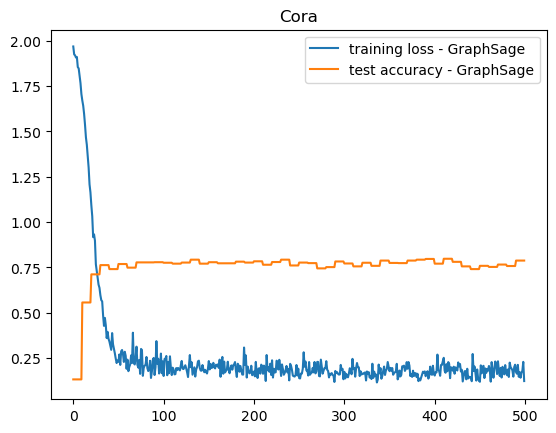

In [34]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()
